This notebook estimates rough distance between GSV camera and closest building as gap-filling depth measure.

## Import dependencies
* Functions on geometry restoration are contained in the geometry.py module.

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np
import os
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
from shapely.geometry import Point, LineString, Polygon
from tqdm import tqdm
from pyproj import Proj, Transformer

## Set input files
* Building points file containing GSV panorama metadata
* Building footprint file

In [59]:
# Launceston
building_point_file=r'D:\Launceston\GSV\LC_Final_meta_camera_height_ground_elevations.geojson'
building_footprint_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\overture\launceston_building.gpkg'

In [60]:
# # Wagga
# building_point_file=r'D:\Wagga\GSV\Final_Wagga_meta_camera_height_ground_elevations.geojson'
# building_footprint_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\overture\wagga_building.gpkg'

## Read in building points file and extract GSV camera locations

In [61]:
projected_crs="EPSG:3857"
transformer = Transformer.from_crs("EPSG:4326", projected_crs, always_xy=True)

In [62]:
gdf_points=gpd.read_file(building_point_file).to_crs(projected_crs)
gdf_points.head()

,EASTING,NORTHING,UFI,ZONE,DEM,LID,ADDRESS,SUBURB,POSTCODE,FEATURE_NA,...,pitch,roll,elevation,date,height_c,grd_elev_GSV,grd_elev_building_min,grd_elev_building_mean,grd_elev_building_max,geometry
0,510962.988188,5.412541e+06,1002,15.0 Urban Mixed Use,2.697813,GNAF_GATAS702308914,13 PARK STREET,LAUNCESTON,7250,None,...,0.022252,6.228637,5.546635,2019-10,2.298505,2.697813,2.32000,2.718059,3.013333,POINT (16378573.381 -5077255.621)
1,511021.688427,5.412248e+06,33,11.0 Inner Residential,4.208417,GNAF_GATAS702204375,293 BRISBANE STREET,LAUNCESTON,7250,None,...,0.037883,6.235322,5.922997,2023-09,2.547754,4.208417,4.18531,4.789202,5.885000,POINT (16378652.195 -5077648.094)
2,511082.136711,5.412226e+06,31,11.0 Inner Residential,4.540370,GNAF_GATAS702478623,4 MIDDLE STREET,LAUNCESTON,7250,None,...,0.039241,0.022607,7.156610,2023-09,2.427306,4.540370,4.10874,4.491268,4.910000,POINT (16378732.79 -5077677.2)
3,511068.760790,5.412219e+06,28,11.0 Inner Residential,5.212643,GNAF_GATAS702296648,6 MIDDLE STREET,LAUNCESTON,7250,None,...,0.051902,0.010492,7.739836,2023-09,2.578520,5.212643,3.88800,4.751154,5.595274,POINT (16378714.979 -5077685.813)
4,511048.726805,5.412229e+06,26,11.0 Inner Residential,5.162260,GNAF_GATAS702290011,8 MIDDLE STREET,LAUNCESTON,7250,None,...,0.034847,0.021449,8.384348,2023-09,2.563187,5.162260,4.53000,5.015464,5.865000,POINT (16378688.262 -5077672.596)


In [63]:
gdf_footprint=gpd.read_file(building_footprint_file).to_crs(projected_crs)
gdf_footprint.head()

,id,min_height_ahd,max_height_ahd,geometry
0,5ba66050-bb4c-44ae-a94d-ba2225385e8b,211.220,211.925,"POLYGON ((16373316.696 -5079316.623, 16373323...."
1,4175cad2-999d-44e3-a6b7-deb2bc25009e,211.700,211.740,"POLYGON ((16373333.458 -5079328.723, 16373342...."
2,e212aad3-a557-4123-bbef-b817dae4aa9b,211.350,211.790,"POLYGON ((16373346.295 -5079327.55, 16373356.3..."
3,a3dc6530-7b7c-41e5-bca9-c30c879598da,207.660,210.443,"POLYGON ((16373290.367 -5079263.025, 16373273...."
4,4bb13f43-5d95-4adc-a238-a7cea5b4adad,141.472,142.290,"POLYGON ((16373701.416 -5078587.555, 16373700...."


## Calculate distance between camera and building facade
* matching building footprint with the nearest GSV pano location
* intersect with building outline

In [69]:
intersection.geometryType

<bound method BaseGeometry.geometryType of <LINESTRING (16379568.651 -5073939.273, 16379564.547 -5073932.906)>>

In [64]:
gdf_points_updated=gdf_points.copy()
distances=[]
for idx, point in tqdm(gdf_points_updated.iterrows(),total=len(gdf_points_updated)):
    # Find the nearest building footprint
    gdf_footprint['distance']=gdf_footprint['geometry'].apply(lambda x: point.geometry.distance(x))
    nearest_poly = gdf_footprint.loc[gdf_footprint['distance'].idxmin()]
    # Create a line from the camera position in the direction of building centre point
    if np.isnan(point['lng_c']) or np.isnan(point['lat_c']):
        print('no pano information available')
        distances.append(None)
    else:
        camera_x, camera_y = transformer.transform(point['lng_c'], point['lat_c'])
        camera_coords=Point(camera_x,camera_y)
        building_centroid=nearest_poly.geometry.centroid
        direction_line = LineString([camera_coords, (building_centroid.x,building_centroid.y)])
        # Calculate intersection with the building outline
        intersection = nearest_poly.geometry.intersection(direction_line)
        if not intersection.is_empty:
            dist = camera_coords.distance(intersection)
        else:
            print('no intersection, using distance to centre point instead')
            # If no intersection, estimate Z as the distance to the building center
            dist = camera_coords.distance(Point(point.geometry.x,point.geometry.y))
        distances.append(dist)

 17%|█▋        | 221/1276 [01:16<05:57,  2.95it/s]

no pano information available


 18%|█▊        | 226/1276 [01:18<05:56,  2.94it/s]

no pano information available


 19%|█▊        | 238/1276 [01:22<05:44,  3.02it/s]

no pano information available


 19%|█▊        | 239/1276 [01:22<05:50,  2.96it/s]

no pano information available


 20%|█▉        | 251/1276 [01:26<05:55,  2.89it/s]

no pano information available


 20%|██        | 259/1276 [01:29<05:52,  2.88it/s]

no pano information available


 21%|██        | 263/1276 [01:31<05:41,  2.96it/s]

no pano information available


 22%|██▏       | 278/1276 [01:36<07:16,  2.29it/s]

no pano information available


 22%|██▏       | 281/1276 [01:37<06:17,  2.63it/s]

no pano information available


 39%|███▉      | 496/1276 [02:59<04:24,  2.95it/s]

no pano information available


 62%|██████▏   | 796/1276 [04:47<02:42,  2.95it/s]

no pano information available


 88%|████████▊ | 1118/1276 [06:43<00:53,  2.93it/s]

no pano information available


 93%|█████████▎| 1190/1276 [07:08<00:27,  3.11it/s]

no pano information available


 93%|█████████▎| 1193/1276 [07:09<00:26,  3.10it/s]

no pano information available


 94%|█████████▎| 1194/1276 [07:10<00:26,  3.09it/s]

no pano information available


 94%|█████████▍| 1201/1276 [07:12<00:24,  3.06it/s]

no pano information available


 95%|█████████▍| 1209/1276 [07:14<00:22,  3.01it/s]

no pano information available


 95%|█████████▍| 1210/1276 [07:15<00:21,  3.04it/s]

no pano information available


 95%|█████████▌| 1214/1276 [07:16<00:20,  3.09it/s]

no pano information available


 96%|█████████▌| 1222/1276 [07:19<00:17,  3.08it/s]

no pano information available


 96%|█████████▌| 1223/1276 [07:19<00:17,  3.04it/s]

no pano information available


 96%|█████████▌| 1224/1276 [07:19<00:16,  3.10it/s]

no pano information available


 99%|█████████▉| 1261/1276 [07:32<00:04,  3.03it/s]

no pano information available


 99%|█████████▉| 1264/1276 [07:33<00:03,  3.02it/s]

no pano information available


 99%|█████████▉| 1268/1276 [07:34<00:02,  3.06it/s]

no pano information available


100%|██████████| 1276/1276 [07:37<00:00,  2.79it/s]


In [65]:
# assign new columns for storing statistics
gdf_points_updated['gapfilling_depth'] = distances

### View derived elevations

(array([308., 568., 248.,  59.,  30.,  20.,  10.,   6.,   1.,   1.]),
 array([  0.        ,  11.02290007,  22.04580014,  33.06870021,
         44.09160027,  55.11450034,  66.13740041,  77.16030048,
         88.18320055,  99.20610062, 110.22900069]),
 <BarContainer object of 10 artists>)

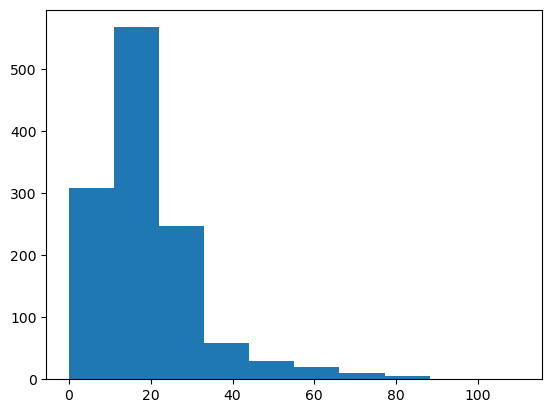

In [66]:
plt.hist([h for h in distances if h is not None])

## Export statistics to file

In [67]:
out_file=r'D:\Launceston\GSV\LC_Final_meta_camera_height_ground_elevations_gapfill_depth.geojson'
gdf_points_updated.to_file(out_file, driver="GeoJSON")